# <font style="color:blue">Semantic Segmentation</font>

In this notebook, we will create a pipeline for semantic segmentation tasks:

1. Start by creating a dataset class
2. Next, closely examine the evaluation metrics to-learn which loss functions are preferred for this task
3. Finally, train a model, putting all of this together


In [ ]:
%%bash
pip install gitdb2
pip install GitPython
pip install -U albumentations --no-binary qudida,albumentations

As always, first, import all the required modules.

In [ ]:
%matplotlib inline

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# math library
import math
# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR

# generic Trainer class imports
from trainer import Trainer, hooks
from trainer.utils import (  # pylint: disable=unused-import
    setup_system,
    patch_configs,
    download_git_folder,
    get_camvid_dataset_parameters,
    draw_semantic_segmentation_batch,
    draw_semantic_segmentation_samples,
    init_semantic_segmentation_dataset,
)
from trainer.base_metric import BaseMetric
from trainer.configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from trainer.matplotlib_visualizer import MatplotlibVisualizer
from trainer.tensorboard_visualizer import TensorBoardVisualizer

# <font style="color:green">1. CamVid Dataset</font>

One of the most popular tasks in semantic segmentation is to segment out  road scenes for self-driving cars. We will use one of the ADAS (Advanced Driver-Assistance Systems) datasets for our experiments - <a href="http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/" target="_blank">the CamVid dataset</a>.

## <font style="color:green">1.1. Dataset Class</font>

Let's create the dataset class:

In [ ]:
# dataset class implementation
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder
            
            Names of images in the images_folder and masks_folder should match the same sample.

    """
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes,
        transforms=None,
        class_names=None,
        dataset_url=None,
        dataset_folder=None
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        # check whether dataset loading parameters exist
        if not os.path.isdir(data_path) and dataset_url is not None and dataset_folder is not None:
            # download CamVid dataset to the predefined directory
            download_git_folder(dataset_url, dataset_folder, data_path)
        # get the map of image-mask pairs
        self.dataset = init_semantic_segmentation_dataset(data_path, images_folder, masks_folder)

    def get_num_classes(self):
        """Get number of classes in the dataset"""
        return self.num_classes

    def get_class_name(self, idx):
        """
            Get a specific class name

            Arguments:
                idx (int): index of specific class.

            Returns:
                If class_names are available and idx < number of classes,
                returns a specific class name, else returns an empty string.
        """
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
        sample = {
            "image": cv2.imread(self.dataset[idx]["image"])[..., ::-1],
            "mask": cv2.imread(self.dataset[idx]["mask"], 0)
        }
        # apply transforms to a sample
        if self.transforms is not None:
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
        return sample

## <font style="color:green">1.2. Visualize CamVid Dataset </font>

Visualize a few samples to  check if your dataset class stores data correctly.

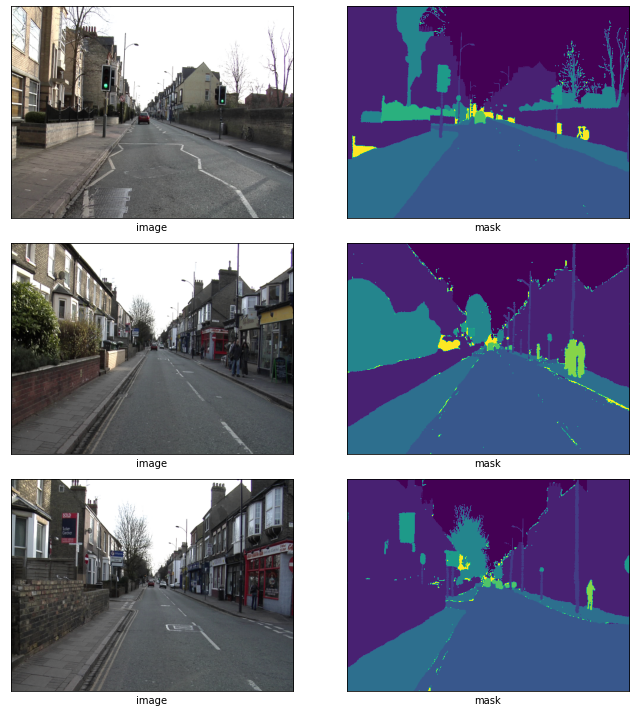

In [ ]:
# create test dataset
test_dataset = SemSegDataset(**get_camvid_dataset_parameters(
        data_path="data",
        dataset_type="test"
    ))
draw_semantic_segmentation_samples(test_dataset, n_samples=3)

# <font style="color:green">2. Evaluation Metrics for Semantic Segmentation </font>

Now, assess  which metrics can be applied to evaluate semantic-segmentation solutions.

## <font style="color:green">2.1. Confusion Matrix Estimator</font>

Confusion matrix is a specific table used to describe the performance of the classification model on test data, for which the true values are known. 
- Each row of the matrix represents the instances in the predicted class 
- Each column represents the instances in the actual class (or vice versa).

Based on the  confusion matrix, create more metrics like Intersection over Union.

In [ ]:
# create confusion matrix class
class ConfusionMatrix(BaseMetric):
    """
        Implementation of Confusion Matrix.

        Arguments:
            num_classes (int): number of evaluated classes.
            normalized (bool): if normalized is True then confusion matrix will be normalized.
    """
    def __init__(self, num_classes, normalized=False):
        # init confusion matrix class fields
        self.num_classes = num_classes
        self.normalized = normalized
        self.conf = np.ndarray((num_classes, num_classes), np.int32)
        self.reset()

    def reset(self):
        """
            Reset of the Confusion Matrix.
        """
        self.conf.fill(0)

    def update_value(self, pred, target):
        """
            Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if torch.is_tensor(pred):
            # convert the prediction tensor to numpy array
            pred = pred.detach().cpu().numpy()
        if torch.is_tensor(target):
            # convert the target tensor to numpy array
            target = target.detach().cpu().numpy()

        # get rid of invalid indices
        valid_indices = np.where((target >= 0) & (target < self.num_classes))
        pred = pred[valid_indices]
        target = target[valid_indices]

        # calculate confusion matrix value for new predictions
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T
        conf, _ = np.histogramdd(
            replace_indices,
            bins=(self.num_classes, self.num_classes),
            range=[(0, self.num_classes), (0, self.num_classes)]
        )
        # update confusion matrix value
        self.conf += conf.astype(np.int32)

    def get_metric_value(self):
        """
            Return the Confusion Matrix.

            Returns:
                numpy.ndarray(num_classes, num_classes): confusion matrix.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            # get normalized confusion matrix
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        return self.conf

## <font style="color:green">2.2. Intersection Over Union Estimator</font>

The `Jaccard index`, also known as `Intersection Over Union` and the `Jaccard similarity coefficient`,
is a statistic used to estimate the similarity and diversity of sample sets. The `Jaccard coefficient` measures similarity between finite sample sets, and is defined as the size of the
intersection divided by the size of the union of the sample sets.

In [ ]:
# create intersection over union class
class IntersectionOverUnion(BaseMetric):
    """
        Implementation of the Intersection over Union metric.

        Arguments:
            num_classes (int): number of evaluated classes.
            reduced_probs (bool): if True, then argmax was applied to the input predictions.
            normalized (bool): if normalized is True, then confusion matrix will be normalized.
            ignore_indices (int or iterable): list of ignored classes indices.
    """
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        # created a normalized confusion matrix with num_classes
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        # check whether ignored classes exist
        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        """
            Reset the Confusion Matrix
        """
        self.conf_matrix.reset()

    def update_value(self, pred, target):
        """ Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.update_value(pred, target)

    def get_metric_value(self):
        """
            Return mIOU and IOU per class.

            Returns:
                miou (float32): mean intersection over union.
                iou (list): list of intersection over union per class.
        """
        # get confusion matrix value
        conf_matrix = self.conf_matrix.get_metric_value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate iou by its formula
            iou = true_positive / (true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            iou_valid_cls = np.delete(iou, self.ignore_indices)
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou_valid_cls)
        else:
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou)
        return {"mean_iou": miou, "iou": iou}

## <font style="color:green">2.3. Compute Intersection Over Union</font>

Let's practise  calculating the metric. Because we add ground-truth values as predicted values, the result should be equal to `1`.

In [ ]:
# create intersection over union instance
metric = IntersectionOverUnion(num_classes=test_dataset.get_num_classes(), reduced_probs=True)
# add samples from test dataset and update metrics value
for sample in tqdm(test_dataset, ascii=False):
    masks = sample["mask"]
    metric.update_value(masks, masks)
# get the mean iou value
values = metric.get_metric_value()
print(values['mean_iou'])
print(values['iou'])

  0%|          | 0/233 [00:00<?, ?it/s]

1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# <font style="color:green">3. Model for Semantic Segmentation</font>

## <font style="color:green">3.1. Encoder for Semantic Segmentation</font>

Unlike classification, in semantic segmentation we usually use pyramids of multi-scale
features for pixel-wise classification. It's one way to recover the spatial resolution lost in deep layers.
Let's implement a multi-scale encoder using a pretrained ResNet model.

In [ ]:
# create resnet encoder module
class ResNetEncoder(nn.Module):
    """ ResNet encoder.

        Arguments:
            resnet_type (string): type of resnet (all resnet network which exist in torchvision).
            pretrained (bool): if pretrained == True, ImageNet weights will load.
    """
    def __init__(self, resnet_type="resnet18", pretrained=True):
        super().__init__()
        # get PyTorch ResNet18 as feature extractor
        self.module = getattr(models, resnet_type)(pretrained=pretrained)

    # get output
    def get_channels_out(self):
        """
            Get num channels of output feature pyramid.

            Returns:
                List of num channels for each feature pyramid layer.
        """
        channels_out = []
        for layer in [getattr(self.module, "layer{}".format(i)) for i in range(1, 5)]:
            channels_out.append(self._get_block_size(layer))
        return channels_out[::-1]

    # define forward pass
    def forward(self, x):
        # init PyTorch ResNet18 layers
        # output number of channels = 64
        x = self.module.conv1(x)
        # output number of channels = 64
        x = self.module.bn1(x)
        # output number of channels = 64
        x = self.module.relu(x)
        # output number of channels = 64
        x = self.module.maxpool(x)

        # output number of channels = 64
        l1_output = self.module.layer1(x)
        # output number of channels = 128
        l2_output = self.module.layer2(l1_output)
        # output number of channels = 256
        l3_output = self.module.layer3(l2_output)
        # output number of channels = 512
        l4_output = self.module.layer4(l3_output)

        return l1_output, l2_output, l3_output, l4_output

    # get size of a module
    @staticmethod
    def _get_block_size(module):
        return list(module[-1].modules())[-2].weight.size()[0]

## <font style="color:green">3.2. FPN Decoder for Semantic Segmentation</font>

To aggregate features from different resolutions, we got a simple strategy: make two layers have the same scale and sum them.

In [ ]:
# create connection layers between encoder and decoder blocks
class LateralConnection(nn.Module):
    """
        Lateral connection.

        Arguments:
            channels_in (int): number of input channels.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # create output number of channels from input
        self.proj = nn.Conv2d(channels_in, channels_out, kernel_size=1)

    # define forward pass
    def forward(self, prev, cur):
        # interpolating the previous feature map
        up = F.interpolate(prev, cur.size()[-2:], mode="nearest")
        # project consistent number of channels
        proj = self.proj(cur)
        # summarize feature maps into one
        return proj + up


# create decoder module
class FPNDecoder(nn.Module):
    """
        Feature Pyramid Decoder.
            Aggregate all feature pyramid layers using lateral connections.

        Arguments:
            channels_in (list): list of input channels for each feature pyramid layer.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out=256):
        super().__init__()
        # init decoder as a list of modules
        self.module = nn.ModuleList()
        # create lateral connections between encoder and decoder blocks
        # for the last encoder block there is no need for upsampling
        self.module.append(nn.Conv2d(channels_in[0], channels_out, kernel_size=1))
        for i in range(1, len(channels_in)):
            self.module.append(LateralConnection(channels_in[i], channels_out))

    # define forward pass
    def forward(self, x):
        # append outputs after each laternl layer
        output = [self.module[0](x[0])]
        for i in range(1, len(x)):
            output.append(self.module[i](output[i - 1], x[i]))
        return output

## <font style="color:green">3.3. Semantic Segmentation Network Using Encoder-Decoder Architecture</font>

Let's implement an architecture for semantic segmentation using the `encoder-decoder` topology.

In [ ]:
# create semantic segmentation model
class SemanticSegmentation(nn.Module):
    """
        Semantic Segmentation model using Feature Pyramid Network.

        Arguments:
            num_classes (int): number of classes.
            encoder_type (class): type of encoder network.
            channels_out (int): number of channels of the output features.
            final_upsample (bool): if final_upsample is True then final prediction will be upsampled to the 
                                   original resolution.
    """
    def __init__(self, num_classes, encoder_type=ResNetEncoder, channels_out=128, final_upsample=False):
        super().__init__()
        # init fields
        self.final_upsample = final_upsample
        self.encoder = encoder_type()
        # create decoder
        self.decoder = FPNDecoder(self.encoder.get_channels_out(), channels_out=channels_out)
        # create classifier with num_classes as output
        self.classifier = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
            nn.Conv2d(channels_out, num_classes, kernel_size=1),
        )

    # define forward pass as a sequence of forward passes between all modules
    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder[::-1])
        classifier = self.classifier(decoder[-1])

        # upsample to the input image size if needed
        if self.final_upsample:
            classifier = F.interpolate(classifier, x.size()[-2:], mode="bilinear", align_corners=False)

        # output number of channels is equal to number of dataset classes
        return classifier

# <font style="color:green">4. Train Semantic Segmentation Models</font>

Now we are ready to build the whole pipeline. The only thing left is to choose which loss to use for
our model training.

To simplify our experiments, we'll determine a simple learning rate policy (constant learning rate through all
training time) and train the network for `30-epochs` only. Kepp experimenting with these hyperparameters to improve
resulting metrics.

## <font style="color:green">4.1. Train Model With nn.CrossEntropyLoss</font>

You  already know that the semantic-segmentation problem is nothing but  a pixel-wise classification problem. So why not go for a simple classification pipeline to train our semanti-segmentation model. Let's try.

In [ ]:
# define experiment class
class Experiment:
    def __init__(
        self,
        # init configs
        system_config: SystemConfig = SystemConfig(),
        dataset_config: DatasetConfig = DatasetConfig(),
        dataloader_config: DataloaderConfig = DataloaderConfig(),
        optimizer_config: OptimizerConfig = OptimizerConfig(),
    ):
        # apply system settings
        self.system_config = system_config
        setup_system(system_config)
        # define train dataloader
        self.loader_train = DataLoader(
            # define our dataset
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="train",
                    # define augmentations
                    transforms=Compose([
                        HorizontalFlip(),
                        ShiftScaleRotate(
                            shift_limit=0.0625,
                            scale_limit=0.50,
                            rotate_limit=45,
                            border_mode=cv2.BORDER_CONSTANT,
                            value=0,
                            mask_value=11,
                            p=.75
                        ),
                        HueSaturationValue(),
                        RandomCrop(height=352, width=480),
                        Normalize(),
                        ToTensorV2()
                    ])
                )
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define test dataloader
        self.loader_test = DataLoader(
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="test",
                    transforms=Compose([Normalize(), ToTensorV2()])
                )
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define model
        self.model = SemanticSegmentation(
            num_classes=self.loader_test.dataset.get_num_classes(), final_upsample=True
        )
        # define loss function as cross-entropy loss
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.loader_test.dataset.get_num_classes())
        # define metrics function as intersection over union
        self.metric_fn = IntersectionOverUnion(
            num_classes=self.loader_test.dataset.get_num_classes(), reduced_probs=False
        )
        # define optimizer and its params
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay
        )
        # define learning rate scheduler
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        # define visualizer
        # self.visualizer = MatplotlibVisualizer()
        self.visualizer = TensorBoardVisualizer()

    # run training
    def run(self, trainer_config: TrainerConfig) -> dict:
        # apply system settings
        setup_system(self.system_config)
        # move training to the chosen device
        device = torch.device(trainer_config.device)
        # send data to chosen device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        # define trainer
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("mask"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mean_iou"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        # define hook to run after each epoch
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_semseg)
        # run the training
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

In [ ]:
# run the experiment
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=30, batch_size_to_set=16, num_workers_to_set=0)

optimizer_config = OptimizerConfig(learning_rate=1e-3, lr_step_milestones =[], weight_decay=4e-5)
experiment = Experiment(dataloader_config=dataloader_config, optimizer_config=optimizer_config)
metrics = experiment.run(trainer_config)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Let's plot the test and train loss curves. Also, we'll plot the test accuracy curve with mean IoU for all classes.

In [ ]:
def plot_metrics(num_classes, metrics):
    plt.rcParams['figure.figsize'] = (20,15)
    plt.style.use('ggplot')
    plt.figure()
    num_cols = 3
    num_rows = math.ceil(num_classes/num_cols)

    ious = {}
    for i in range(num_classes):
        ious["test_iou_"+str(i)]=[]

    for metric_iou in metrics['test_metric']:
        for idx, iou in enumerate(metric_iou['iou']):
            ious["test_iou_"+str(idx)].append(iou)
    
    for id, (iou_cls, iou) in enumerate(ious.items()):
        plt.subplot(num_rows, num_cols, id+1)
        plt.plot(metrics['epoch'], iou, label='train_loss')
        
        plt.xlabel('Epochs')
        plt.ylabel(iou_cls)     

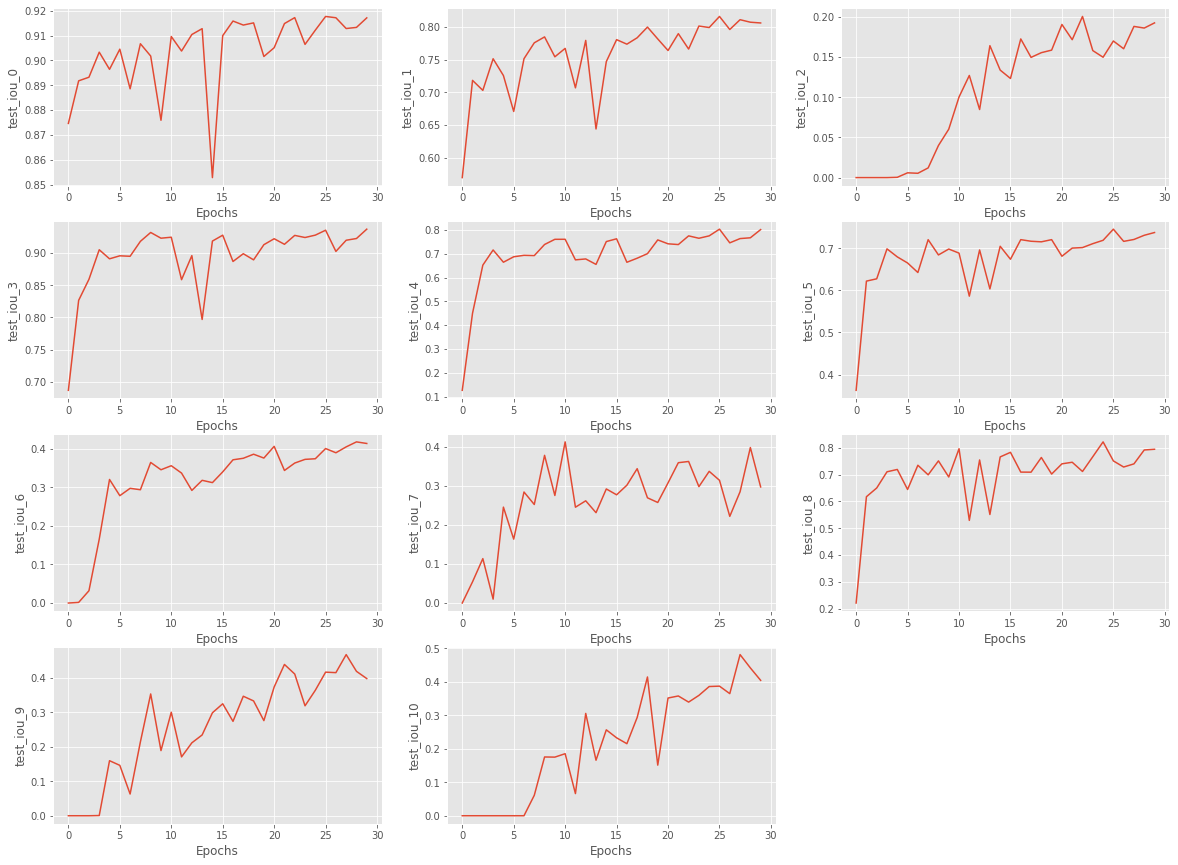

In [ ]:
plot_metrics(experiment.loader_test.dataset.get_num_classes(), metrics)

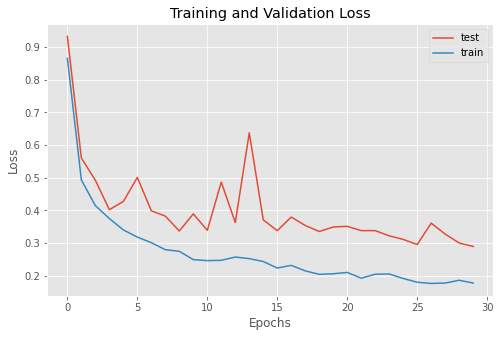

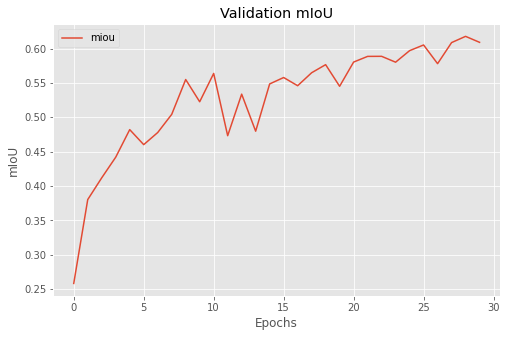

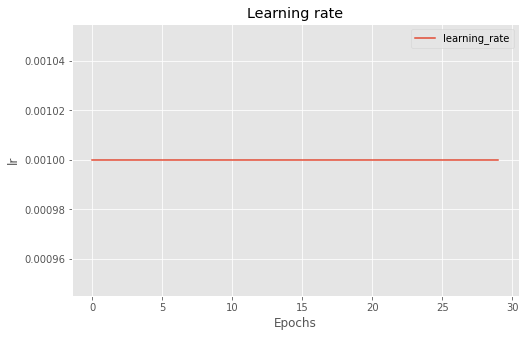

In [ ]:
plt.rcParams['figure.figsize'] = (8,5)
plt.style.use('ggplot')

# create new figure
plt.figure()
# plot test and train loss
plt.plot(metrics["test_loss"], label="test")
plt.plot(metrics["train_loss"], label="train")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['mean_iou'] for metric in metrics["test_metric"]], label="miou")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.title('Validation mIoU')

# create new figure
plt.figure()
# plot learning rate
plt.plot(metrics['learning_rate'], label="learning_rate")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.show()

Let's visualize several test samples and predictions from the network.

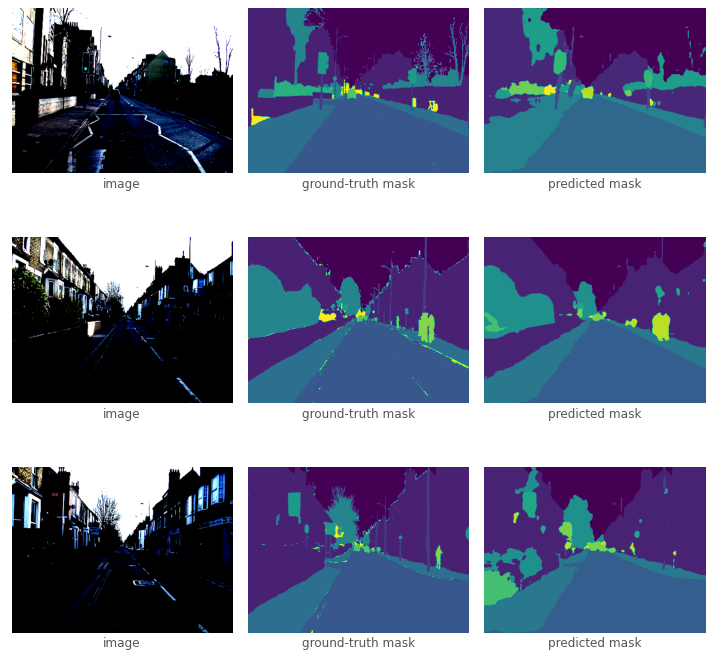

In [ ]:
# get test samples
sample = next(iter(experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)

# get predictions
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)

## <font style="color:green">4.2. Implementation of the SoftJaccardLoss</font>

A good practice for any optimization problem: Optimize the target metric, which will be evaluated. Usually, we evaluate `Intersection Over Union` (or `Jaccard Index`) for semantic-segmentation problems, but this metric cannot be differentiated, and we can't optimize it directly. So, what do we do? How about a continuous relaxation of the Jaccard metric. Here’s one method to implement this:

In [ ]:
# define soft-Jaccard loss
class SoftJaccardLoss(nn.Module):
    """
        Implementation of the Soft-Jaccard Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes, eps=1e-5):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.eps = eps

    # define forward pass
    def forward(self, pred_logits, targets):
        """
            Compute Soft-Jaccard Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # get predictions from logits
        preds = pred_logits.softmax(dim=1)
        loss = 0
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection of predictions and targets
            intersection = (pred * target).sum()

            # compute iou
            iou = (intersection + self.eps) / (pred.sum() + target.sum() - intersection + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - iou.log()

        # get mean loss by class value
        loss = loss / self.num_classes

        return loss

## <font style="color:green">4.3. Implementation of the Focal Loss</font>

Focal loss is designed to:

- assign more weights on hard, easily-misclassified examples
- down-weight easy examples

It is helpful for class-disbalanced problems, where objects of one class appear more often than  others, like the background class in semantic segmentation. Let's implement it.

In [ ]:
# define Focal loss
class FocalLoss(nn.Module):
    """
        Implementation of the Focal Loss function.

        Arguments:
            num_classes (int): number of classes.
                valid_labels: 0,..., num_classes - 1
                ignore_index: num_classes
            gamma (float): parameter which control slope of loss function.
    """
    def __init__(self, num_classes, gamma=2.0, ignore_indices=-1):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.gamma = gamma
        self.ignore_indices = ignore_indices
        self.loss_fn = nn.CrossEntropyLoss(reduction='none', ignore_index=self.ignore_indices)

    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is 
                (B, H, W).
        """
        loss_ce = self.loss_fn(pred_logits, target)
        loss_focal = (1.0 - loss_ce.mul(-1).exp()).pow(self.gamma) * loss_ce
        return loss_focal[target!=self.ignore_indices].mean()

## <font style="color:green">4.4. Implementation of the Multi-Objective Loss Function</font>

Implement the target loss function as a combination of `Soft-Jaccard` and `Focal Loss`, which we will call
`Semantic Segmentation loss`.

In [ ]:
# define semantic segmentation loss
class SemanticSegmentationLoss(nn.Module):
    """
        Implementation of the multi-objective loss function for semantic segmentation.

        Arguments:
            num_classes (int): number of classes.
            jaccard_alpha (float): weight of the SoftJaccardLoss
    """
    def __init__(self, num_classes, jaccard_alpha=0.9, ignore_indices=-1):
        super().__init__()
        # init fields
        self.jaccard_alpha = jaccard_alpha
        self.jaccard = SoftJaccardLoss(num_classes)
        self.focal = FocalLoss(num_classes=num_classes, ignore_indices=ignore_indices)

    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # our loss is a weighted sum of two losses
        jaccard_loss = self.jaccard_alpha * self.jaccard(pred_logits, target)
        focal_loss = self.focal(pred_logits, target)
        loss = jaccard_loss + focal_loss
        return loss

## <font style="color:green">4.5. Train the Model With SoftJaccardLoss + FocalLoss</font>

How good was our implemented loss? Check out by running the same training with it.

In [ ]:
# define experiment with semantic segmentation loss
class ExperimentWithSemanticSegmentationLoss(Experiment):
    def __init__(self, *args, **kwargs):
        # init fields
        super().__init__(*args, **kwargs)
        num_classes = self.loader_test.dataset.get_num_classes()
        self.loss_fn = SemanticSegmentationLoss(num_classes=num_classes, ignore_indices=num_classes)

In [ ]:
# create and run the experiment
semseg_loss_experiment = ExperimentWithSemanticSegmentationLoss(dataloader_config=dataloader_config)
semseg_loss_experiment_metrics = semseg_loss_experiment.run(trainer_config)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Let's plot test and train loss curves. Also, plot the test accuracy curve. It is quite evident that our multi-objective loss function provides slightly-better results.

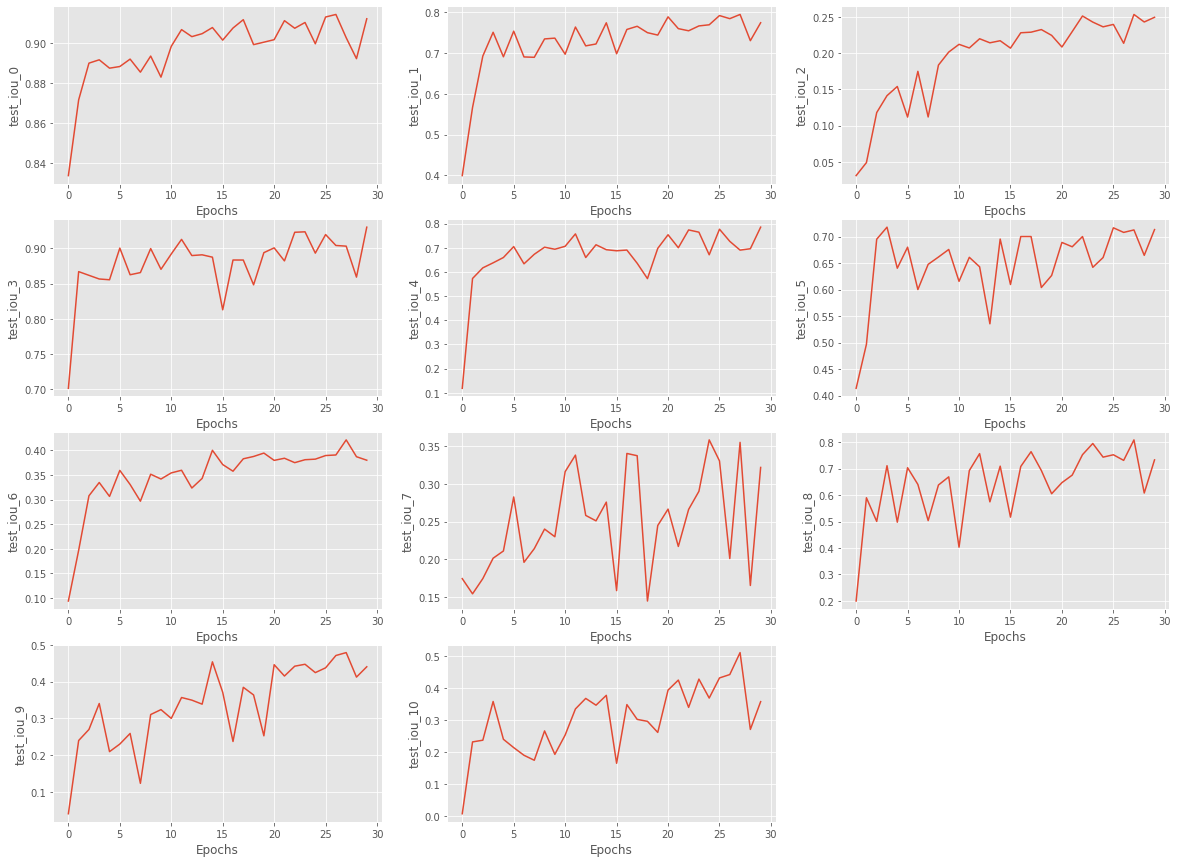

In [ ]:
plot_metrics(semseg_loss_experiment.loader_test.dataset.get_num_classes(), semseg_loss_experiment_metrics)

Let's plot test and train loss curves. Also, plot the test accuracy curve. It is quite evident that our multi-objective loss function provides slightly-better results.

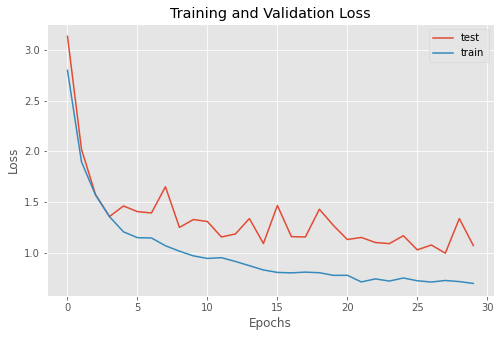

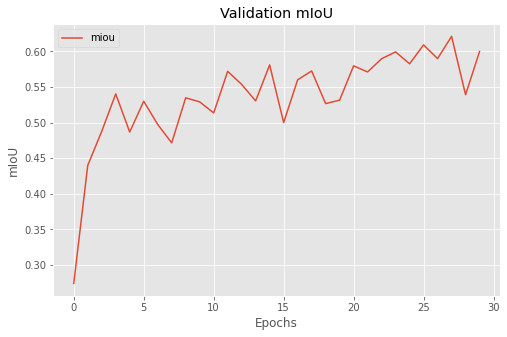

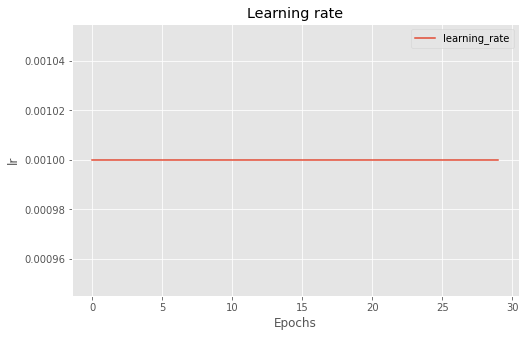

In [ ]:
plt.rcParams['figure.figsize'] = (8,5)
plt.style.use('ggplot')

# create new figure
plt.figure()
# plot test and train loss
plt.plot(semseg_loss_experiment_metrics["test_loss"], label="test")
plt.plot(semseg_loss_experiment_metrics["train_loss"], label="train")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['mean_iou'] for metric in semseg_loss_experiment_metrics["test_metric"]], label="miou")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.title('Validation mIoU')
plt.show()

# create new figure
plt.figure()
# plot learning rate
plt.plot(semseg_loss_experiment_metrics['learning_rate'], label="learning_rate")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.show()

Visualize a few test samples and predictions from the network to see how our predictions look.

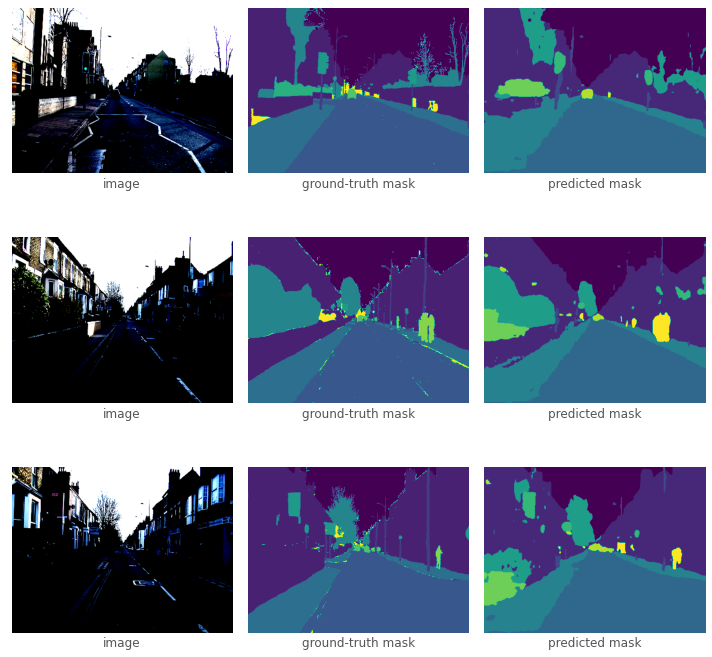

In [ ]:
# get test samples
sample = next(iter(semseg_loss_experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)

# get predictions
preds = semseg_loss_experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)

In [ ]:
def compare_metrics(metrics1, metrics2):
    plt.rcParams['figure.figsize'] = (8,5)
    plt.style.use('ggplot')

    # create new figure
    plt.figure()
    # plot test and train loss
    plt.plot(metrics1["test_loss"], label="test-CE Loss")
    plt.plot(metrics1["train_loss"], label="train-CE Loss")
    plt.plot(metrics2["test_loss"], label="test-(SoftJaccard+Focal Loss)")
    plt.plot(metrics2["train_loss"], label="train-(SoftJaccard+Focal Loss)")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

    # create new figure
    plt.figure()
    # plot mean iou metric for all classes
    plt.plot([metric['mean_iou'] for metric in metrics1["test_metric"]], label="miou-CE Loss")
    plt.plot([metric['mean_iou'] for metric in metrics2["test_metric"]], label="miou-(SoftJaccard+Focal Loss)")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.title('Validation mIoU')
    plt.show()


Finally, we give a comparision between both losses through their loss plots as well as the **mAP** metric on the test data.

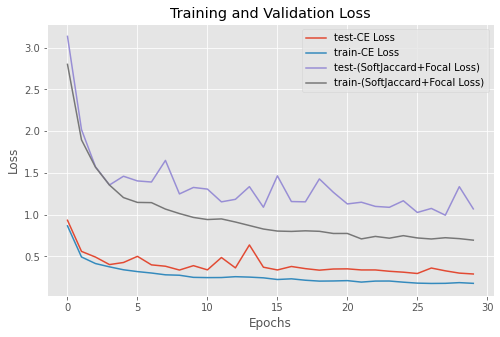

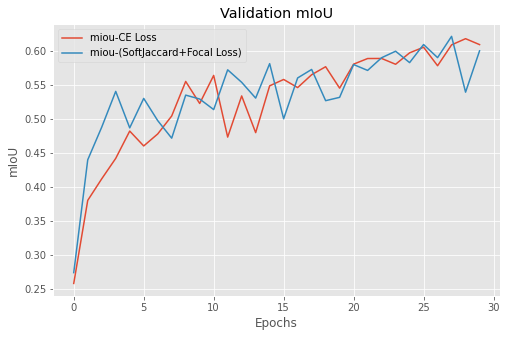

In [ ]:
compare_metrics(metrics, semseg_loss_experiment_metrics)

You can also have a look at our [tensorboard logs](https://tensorboard.dev/experiment/oGjReWkmSWC6970gCyqCnw/#scalars) as well.